In [1]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from typing import List
from sklearn.metrics import ndcg_score, average_precision_score

In [2]:
# load the dataset
animes = pd.read_csv('./data/anime.csv')
ratings = pd.read_csv('./data/rating.csv')

ratings = ratings.sample(1_000_000, random_state=42)

# Preprocessing & Feature Engineering

In [3]:
# select features
animes = animes[['anime_id', 'type', 'rating', 'members', 'name', 'genre']]
# change column names
animes.columns = ['anime_id', 'type', 'anime_total_rating', 'members', 'name', 'genre']
# dropna
animes = animes.dropna()

animes

,anime_id,type,anime_total_rating,members,name,genre
0,32281,Movie,9.37,200630,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
1,5114,TV,9.26,793665,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
2,28977,TV,9.25,114262,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
3,9253,TV,9.17,673572,Steins;Gate,"Sci-Fi, Thriller"
4,9969,TV,9.16,151266,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S..."
...,...,...,...,...,...,...
12289,9316,OVA,4.15,211,Toushindai My Lover: Minami tai Mecha-Minami,Hentai
12290,5543,OVA,4.28,183,Under World,Hentai
12291,5621,OVA,4.88,219,Violence Gekiga David no Hoshi,Hentai
12292,6133,OVA,4.98,175,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai


In [4]:
# rating table
# select features
ratings = ratings[['user_id', 'anime_id', 'rating']]
ratings = ratings[ratings['rating'] != -1]
ratings

,user_id,anime_id,rating
7806172,73424,7785,10
6470262,59789,19769,6
5975474,55960,59,10
7617688,71461,3342,10
5932334,55390,986,8
...,...,...,...
5880179,54908,32013,5
1848650,17901,20159,7
3077643,28493,11111,5
4410201,41616,762,8


In [5]:
# join dataframes
data = ratings.merge(animes, on='anime_id', how='inner')
data

,user_id,anime_id,rating,type,anime_total_rating,members,name,genre
0,73424,7785,10,TV,8.65,122531,Yojouhan Shinwa Taikei,"Mystery, Psychological, Romance"
1,59789,19769,6,TV,6.18,104192,Mahou Sensou,"Action, Fantasy, Magic"
2,55960,59,10,TV,7.57,266846,Chobits,"Comedy, Drama, Ecchi, Romance, Sci-Fi, Seinen"
3,71461,3342,10,TV,7.50,96092,Mnemosyne: Mnemosyne no Musume-tachi,"Action, Horror, Sci-Fi, Shoujo Ai, Supernatural"
4,55390,986,8,Special,7.75,46276,Dragon Ball Z Special 1: Tatta Hitori no Saish...,"Adventure, Comedy, Fantasy, Sci-Fi, Shounen"
...,...,...,...,...,...,...,...,...
810603,54908,32013,5,TV,7.15,45778,Oshiete! Galko-chan,"Comedy, School, Slice of Life"
810604,17901,20159,7,Special,7.94,85947,Pokemon: The Origin,"Action, Adventure, Comedy, Fantasy, Kids"
810605,28493,11111,5,TV,7.88,534657,Another,"Horror, Mystery, School, Supernatural, Thriller"
810606,41616,762,8,Special,7.21,78111,Bleach: Memories in the Rain,"Action, Adventure, Drama, Shounen, Supernatural"


In [6]:
# 유저 정보가 없으므로, 유저의 평점 패턴에서 유저 피쳐 추출 (평균 평점 및 평점을 내린 수)
user_avg_rating = data.groupby('user_id')['rating'].mean().rename('User-AvgRating')
user_num_ratings = data.groupby('user_id')['rating'].count().rename('User-NumRatings')

# 추출한 유저 피쳐 결합
user_features = pd.concat([user_avg_rating, user_num_ratings], axis=1)
user_features

,User-AvgRating,User-NumRatings
user_id,,
3,7.666667,6
5,4.700000,60
7,7.586957,46
10,9.500000,2
11,7.200000,10
...,...,...
73508,10.000000,2
73510,7.227273,22
73511,10.000000,1


In [7]:
# 애니 메타 데이터에서 아이템 관련 피쳐 수가 생성
item_num_ratings = data.groupby('anime_id')['rating'].count().rename('Item-NumRatings')

# 애니 이름 피쳐에서 TF-IDF 피쳐 생성, 총 10개의 이름 생성 (most frequent 10 words)
tfidf_vectorizer = TfidfVectorizer(max_features=10)
item_name_tfidf = tfidf_vectorizer.fit_transform(animes['name']).toarray()

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [8]:
# 'type' column one-hot encoding
onehot_encoder = OneHotEncoder()
item_type_onehot = onehot_encoder.fit_transform(animes[['type']]).toarray()

In [9]:
# TF-IDF 피쳐와 type one hot 피쳐 결합
tf_idf_df = pd.DataFrame(item_name_tfidf, columns=tfidf_feature_names, index=animes.anime_id)
type_df = pd.DataFrame(item_type_onehot, columns=[f'Type-{cat}' for cat in onehot_encoder.categories_[0]], index=animes.anime_id)

anime_features = animes[['anime_id', 'members', 'anime_total_rating']]

item_features = pd.DataFrame(item_num_ratings)\
    .merge(tf_idf_df, on='anime_id')\
    .merge(type_df, on='anime_id')\
    .merge(anime_features.set_index('anime_id'), on='anime_id')
    
item_features

,Item-NumRatings,chan,ga,movie,ni,no,special,specials,the,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
anime_id,,,,,,,,,,,,,,,,,,,
1,1722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,486824,8.82
5,773,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,137636,8.40
6,1169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,283069,8.32
7,262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64905,7.36
8,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9848,7.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34103,78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,29969,8.10
34240,161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,71136,8.38
34283,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,937,6.74


In [10]:
# 인터랙션 데이터와 함께 user 및 item 피쳐 결합
data = data.drop(['anime_total_rating', 'members'], axis=1)

data = data.join(user_features, on='user_id')
data = data.merge(item_features, on='anime_id')

# implicit feedback 표현을 위해 이진화 (유저의 평균 평점보다 높은 경우 1)
data['rating'] = (data['rating'] > data['User-AvgRating']).astype(int)

data


,user_id,anime_id,rating,type,name,genre,User-AvgRating,User-NumRatings,Item-NumRatings,chan,...,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
0,73424,7785,1,TV,Yojouhan Shinwa Taikei,"Mystery, Psychological, Romance",7.241379,29,197,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,122531,8.65
1,59789,19769,0,TV,Mahou Sensou,"Action, Fantasy, Magic",7.573770,61,358,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,104192,6.18
2,55960,59,1,TV,Chobits,"Comedy, Drama, Ecchi, Romance, Sci-Fi, Seinen",9.166667,12,1236,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,266846,7.57
3,71461,3342,1,TV,Mnemosyne: Mnemosyne no Musume-tachi,"Action, Horror, Sci-Fi, Shoujo Ai, Supernatural",8.538462,13,408,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,96092,7.50
4,55390,986,0,Special,Dragon Ball Z Special 1: Tatta Hitori no Saish...,"Adventure, Comedy, Fantasy, Sci-Fi, Shounen",8.281250,32,292,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,46276,7.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810603,54908,32013,0,TV,Oshiete! Galko-chan,"Comedy, School, Slice of Life",7.129032,31,110,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,45778,7.15
810604,17901,20159,0,Special,Pokemon: The Origin,"Action, Adventure, Comedy, Fantasy, Kids",8.250000,4,410,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,85947,7.94
810605,28493,11111,0,TV,Another,"Horror, Mystery, School, Supernatural, Thriller",6.517241,58,2164,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,534657,7.88
810606,41616,762,1,Special,Bleach: Memories in the Rain,"Action, Adventure, Drama, Shounen, Supernatural",7.444444,36,451,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,78111,7.21


In [11]:
# train-test split
X = data.drop(columns=['user_id', 'anime_id', 'rating', 'type', 'name', 'genre'])
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

  0%|          | 0/2 [00:00<?, ?it/s]

Training LGBN with 1000 sample...
[LightGBM] [Info] Number of positive: 511, number of negative: 489
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511000 -> initscore=0.044007
[LightGBM] [Info] Start training from score 0.044007
LGBN AUC: 0.6699617456939394
Training EBM with 1000 sample...
EBM AUC: 0.7097897551218354


  0%|          | 0/2 [00:00<?, ?it/s]

Training LGBN with 10000 sample...
[LightGBM] [Info] Number of positive: 5100, number of negative: 4900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1343
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510000 -> initscore=0.040005
[LightGBM] [Info] Start training from score 0.040005
LGBN AUC: 0.7373861060924406
Training EBM with 10000 sample...
EBM AUC: 0.7447568873300376


  0%|          | 0/2 [00:00<?, ?it/s]

Training LGBN with 100000 sample...
[LightGBM] [Info] Number of positive: 50720, number of negative: 49280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1436
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507200 -> initscore=0.028802
[LightGBM] [Info] Start training from score 0.028802
LGBN AUC: 0.7518751278614869
Training EBM with 100000 sample...
EBM AUC: 0.7525107228154377


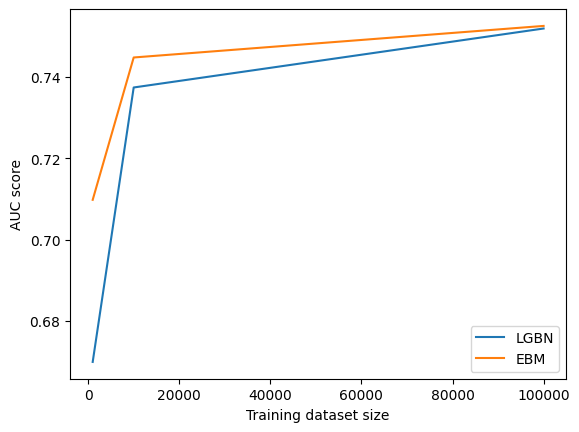

In [13]:
# dataset size
dataset_sizes = [1_000, 10_000, 100_000]

# models 
models = {
    'LGBN': LGBMClassifier(random_state=42),
    'EBM': ExplainableBoostingClassifier(random_state=42)
}

# 각 모델별 auc score를 저장하기 위한 dictionary
auc_scores = {model_name: [] for model_name in models.keys()}

# 각 모델별 roc curve 정보 저장을 위해 dictionary 정의
roc_curves = {model_name: [] for model_name in models.keys()}

# iterate for data sizes
for size in dataset_sizes:
    
    # 각 사이즈별로 데이터 샘플링
    X_train_sample = X_train.sample(n=size, random_state=42)
    y_train_sampels = y_train.loc[X_train_sample.index]
    
    # iterate for models
    for model_name, model in tqdm(models.items()):
        print(f"Training {model_name} with {size} sample...")
        
        # fit model
        model.fit(X_train_sample, y_train_sampels)
        
        # predict
        y_pred = model.predict_proba(X_test)[:, 1]
        
        # calculate AUC
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores[model_name].append(auc_score)
        
        # ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_curves[model_name].append((fpr, tpr))
        
        print(f"{model_name} AUC: {auc_score}")
        
# Visualize AUC scores
for model_name, model_auc_scores in auc_scores.items():
    plt.plot(dataset_sizes, model_auc_scores, label=model_name)
plt.xlabel('Training dataset size')
plt.ylabel('AUC score')
plt.legend()
plt.show()

In [14]:
%%time
# 100만개 기준 54분
# 10만개 기준 8분

# EBM  모델 인스턴스 생성
ebm = ExplainableBoostingClassifier(random_state=42)

# fit model
ebm.fit(X_train, y_train)

CPU times: total: 1.78 s
Wall time: 4min 57s


ExplainableBoostingClassifier()

In [15]:
# 모델 성능 평가 -> ROC 기준
roc = ROC(ebm.predict_proba).explain_perf(X_test, y_test, name='ROC')
show(roc)

<!-- http://127.0.0.1:7001/1996008344160/ -->

In [16]:
# 글로벌 모델 설명 출력
# 모델 예측에 대한 각 피쳐의 영향도를 나타냄
# 중요도 순으로 피쳐 정렬
global_explanation = ebm.explain_global(name='EBM')
show(global_explanation)

<!-- http://127.0.0.1:7001/1996045309872/ -->

In [17]:
user_id =38

def recommend_top_n(user_id, model, n=5):
    # 아직 유저가 평가하지 않은 애니 가져오기
    user_data = data[data['user_id'] == user_id]
    rated_animes = user_data['anime_id'].unique()
    unrated_animes = item_features[~item_features.index.isin(rated_animes)]
    
    # 유저 정보 붙여주기
    user_feature_df = user_features.loc[user_id]
    unrated_animes = unrated_animes.assign(**user_feature_df)
    
    # 해당 유저 대상으로 모델 예측
    unrated_animes['predicted_rating'] = model.predict_proba(unrated_animes)[:, 1]
    
    # 상위 N개 평점 예측
    top_n_animes = unrated_animes.sort_values('predicted_rating', ascending=False).head(n)
    
    return top_n_animes

In [18]:
# 특정 유저에 대한 상위 n개 예측 생성
top_n = recommend_top_n(user_id, ebm, n=5)[['predicted_rating']]

# top_n개 예측의 상세 정보
top_n_details = top_n.merge(animes, how='left', left_index=True, right_on='anime_id')

print(f'Top 5 anime recommendations for user {user_id}')
display(top_n_details)

Top 5 anime recommendations for user 38


,predicted_rating,anime_id,type,anime_total_rating,members,name,genre
2,0.973942,28977,TV,9.25,114262,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
5,0.968924,32935,TV,9.15,93351,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports"
9,0.966188,15417,TV,9.11,81109,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S..."
0,0.965828,32281,Movie,9.37,200630,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
7,0.965735,820,OVA,9.11,80679,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space"


In [19]:
# 좋은 평점을 준 애니 검색
user_ratings = ratings[ratings['user_id'] == user_id]
well_rated_animes = user_ratings[user_ratings['rating'] >= user_ratings['rating'].mean()]

# 상세 정보 조회
well_rated_details = animes[animes['anime_id'].isin(well_rated_animes['anime_id'])]

# 평점 정보를 포함한 좋은 평점 정보 출력
well_rated_details = well_rated_details.merge(well_rated_animes[['anime_id', 'rating']], on='anime_id', how='inner')

In [20]:
# 원하는 user_id에 해당하는 user-item pair 샘플의 index를 가져옴
# 혹은 sample_idx를 임의로 정해줄 수 있음
sample_idx = data[data.user_id == user_id].index[0]

In [21]:
# 해당 인덱스를 X_test에서 찾음
instance = X_test[X_test.index==sample_idx]
instance

,User-AvgRating,User-NumRatings,Item-NumRatings,chan,ga,movie,ni,no,special,specials,...,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating


In [22]:
# 해당 유저/아이템 id 다시 가져옴
user_id_for_local_explanation = data.iloc[sample_idx]['user_id']
anime_id_for_local_explantation = data.iloc[sample_idx]['anime_id']

# 유저의 평점 기록 로드
user_rating_history = ratings[ratings['user_id'] == user_id_for_local_explanation]

# 유저 평점 기록과 애니 메타 데이터 합성
user_rating_history_with_names = user_rating_history.merge(animes, on='anime_id')

# 유저의 평점 기록을 이름과 함꼐 출력
print('\n')

display(f"User {user_id_for_local_explanation}'s rating history")
display(user_rating_history_with_names)

# 타겟 애니의 메타 정보 호출
anime_details = animes[animes['anime_id'] == anime_id_for_local_explantation]

# 애니 정보까지 포함
print('\n')
display(f'Anime details for the anime:')
display(anime_details) 

"User 38's rating history"

,user_id,anime_id,rating,type,anime_total_rating,members,name,genre
0,38,27831,9,TV,8.12,132506,Durarara!!x2 Ten,"Action, Mystery, Supernatural"
1,38,16009,9,TV,7.53,122031,Kamisama no Inai Nichiyoubi,"Fantasy, Mystery"
2,38,20583,10,TV,8.68,284498,Haikyuu!!,"Comedy, Drama, School, Shounen, Sports"
3,38,26243,5,TV,7.65,315630,Owari no Seraph,"Action, Drama, Shounen, Supernatural, Vampire"
4,38,3588,8,TV,8.08,580184,Soul Eater,"Action, Adventure, Comedy, Fantasy, Shounen, S..."
5,38,31904,7,TV,5.70,84079,Big Order (TV),"Action, Shounen, Super Power"
6,38,23321,10,TV,7.66,215817,Log Horizon 2nd Season,"Action, Adventure, Fantasy, Game, Magic, Shounen"
7,38,23421,8,TV,7.48,73903,Re:␣Hamatora,"Comedy, Mystery, Super Power"
8,38,9065,5,TV,7.76,49771,Hakuouki Hekketsuroku,"Action, Drama, Historical, Josei, Samurai, Sup..."
9,38,1575,10,TV,8.83,715151,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super..."


'Anime details for the anime:'

,anime_id,type,anime_total_rating,members,name,genre
391,27831,TV,8.12,132506,Durarara!!x2 Ten,"Action, Mystery, Supernatural"


In [23]:
# 로컬 설명 출력
# 로컬 설명은 한 인스턴스에 대한 예측의 피쳐별 기여도를 보여줌
local_explanation = ebm.explain_local(X_test[X_test.index == sample_idx], y_test[y_test.index == sample_idx], name='EBM')
show(local_explanation)

<!-- http://127.0.0.1:7001/1996308500720/ -->